# コーナー検出のためのFASTアルゴリズム
## 目的
このチュートリアルでは
* FASTアルゴリズムの基礎を理解する
* FASTアルゴリズムのOpenCV関数を使ってコーナーを見つけ出す

## 理論
今までに特徴検出器をいくつか見てきた。そしてその多くは実際に役に立つものであった。しかし、実用という観点から言えば、十分速いものとはいえない。その良い例は、計算リソースが限られているSLAM（自己位置推定と地図作成の同時進行)を行うモバイル・ロボットである。

このような問題の解として、2006年にFAST (Features from Accelerated Segment Test、加速化断片試験による特徴抽出)アルゴリズムがEdward Rosten & Tom Drummond によって “Machine learning for high-speed corner detection (高速コーナー検出のための機械学習)”で提案された。以下にその基本的な要点を述べる。詳しくは原論文を参照のこと(図はすべて原論文からのものである)。

## FASTを用いた特徴抽出


1. 注目点かどうかの判定のため、画像中のピクセルを一つ選び $p$ とする。 その画素値を $I_p$とする。

2. 適当な閾値 $t$を選ぶ。

3. ピクセルpを中心とする円上の16ピクセルを考える (下の画像をみよ)
![A corner in the image](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/fast_speedtest.jpg)
4. ここでピクセル $p$がコーナーである条件は、この(16ピクセルからなる)円において、すべて$I_p + t$よりも明るいか、すべて$I_p − t$よりも暗い $n$ 個の連続ピクセルが存在することである。(上の図では白色点線で示されている).ここで $n$ の値は(次に述べる高速試験のため) 12が選ばれている.

5. コーナーでないものを排除するために 高速試験 が提案された。この試験は1, 5, 9 13の4つの($p$からみて上下左右の位置にある)ピクセルだけを調べる。もしも $p$ がコーナーであれば、このうちの少なくとも3つはすべて$ I_p + t $よりも明るいか、$ I_p − t$よりも暗くなければならない。どちらの場合もあてはまらなければ、 $p$はコーナーではありえない。この試験に通った候補に対しては、円周上のすべてのピクセルを調べるという全断片試験が行われる。この検出器の性能は高いものであるが、いくつか問題点もある:
     - $n < 12$の場合、高速試験が使えない。
    - ピクセルの選択と調査の順番は特徴の出現分布に暗黙的に依存している。
    - 高速試験の結果が無駄に捨てられてしまう。
    - 隣接領域において注目点を多重に検出してしまう。
    
上記の問題点のうち、最初の3つに対しては機械学習により解決する。最後の問題点には非最大値抑制により扱う。



## コーナー検出の機械学習

1. 学習用に画像のセットを選ぶ (対象とする応用分野からの画像が望ましい)

2. FASTアルゴリズムを学習用の画像に適用し、特徴点を検出する

3. すべての特徴点に対し、その周囲の16ピクセルをベクトルとして記録する。これをすべての画像に対して行い、特徴ベクトル Pを作る

4. これら16ピクセルのそれぞれに対し(そのピクセルをxとする)次の3つの状態の一つを割り当てる:
　　　　　　$\displaystyle S_{p \rightarrow x} = \left\{ \begin{array}{ccccr} d, & & I_{p\rightarrow x} & \leq I_p - t& (darker)\\
s, & I_p - t < & I_{p \rightarrow x} & <I_p + t & (similar)\\
b, & I_p + t \leq & I_{p\rightarrow x} & & (brighter) \end{array} \right.$
5. この状態に基づき、特徴ベクトル P を3つのサブセット $P_d$, $P_s$, $P_b$に分割する

6. 新たなブール値変数 $K_p$を定義する：その値は $p$ がコーナーなら真、そうでなければ偽とする

7. ID3 アルゴリズム (決定木による分類器)を用いて変数 $K_p$ に基づき「真」のクラスについての判別基準を学習する。$K_p$ のエントロピー基準で、候補ピクセルがコーナーかどうかについて最大の情報利得が得られる決定木を生成する.

8. エントロピーが0になるまですべてのサブセットに対しこの手順を繰り返す

9. こうして作られた決定木を他の画像におけるコーナー検出に用いる

## 非最大値抑制
隣接領域に注目点を多重に検出してしまうのは、もうひとつの問題である。これは非最大値抑制によって解決される。

1. スコア関数 V をすべての検出された特徴点に対して計算する。ここで V はp とその周辺 16 個のピクセル値それぞれとの差の絶対値の和とする。
2. 2個の隣接するキーポイントに対し、その V値を計算する。
3. 2つのうちどちらか V値の小さい方を候補から外す.

## まとめ
このアルゴリズムによる検出器は現存する他のものと比べて数倍速い。

しかし、高次のノイズに弱い。頑健さは閾値に依存する。

## OpenCVにおけるFAST特徴検出
OpenCVでは他の検出器同様、[cv2.FastFeatureDetector_create({, threshold{, nonmaxSuppression{, type}}})](http://docs.opencv.org/3.0-beta/modules/features2d/doc/feature_detection_and_description.html?highlight=fast)関数を用いてFASTオブジェクトをまず作る。このとき、次のオプションの指定が可能である:閾値の設定(threshold)、非最大値抑制を適用するかどうか(nonmaxSuppression)、(次で説明する)周辺領域の選択(type)、など。

周辺領域のオプションについては、次の3つのフラグが定義されている: `cv2.FAST_FEATURE_DETECTOR_TYPE_5_8`, `cv2.FAST_FEATURE_DETECTOR_TYPE_7_12`、`cv2.FAST_FEATURE_DETECTOR_TYPE_9_16`。以下はFAST特徴点検出を用いた特徴点の検出と図示の方法を示すための簡単なコードである。([使用する画像](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/py_tutorials/py_feature2d/py_fast/blox.jpg))

Threshold:  10
nonmaxSuppression:  True
neighborhood:  2
Total Keypoints with nonmaxSuppression: 431
Total Keypoints without nonmaxSuppression:  1575


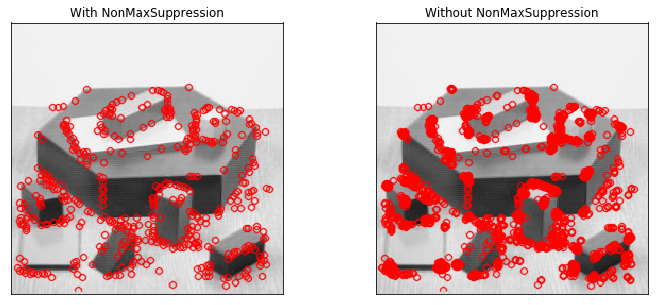

In [6]:
%matplotlib inline
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('blox.jpg',0)

# まずデフォルト値で FASTオブジェクトを作る
fast = cv2.FastFeatureDetector_create()

# キーポイントを求めて描画する
kp = fast.detect(img,None)
img2 = cv2.drawKeypoints(img, kp,None,color=(255,0,0))

# デフォルトのパラメタをすべて表示
print("Threshold: ", fast.getThreshold())
print("nonmaxSuppression: ", fast.getNonmaxSuppression())
print("neighborhood: ", fast.getType())
print("Total Keypoints with nonmaxSuppression:", len(kp))

# cv2.imwrite('fast_true.png',img2)

# nonmaxSuppressionを停止
fast.setNonmaxSuppression(0)
kp = fast.detect(img,None)

print("Total Keypoints without nonmaxSuppression: ", len(kp))

img3 = cv2.drawKeypoints(img, kp,None,color=(255,0,0))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1), plt.imshow(img2)
plt.xticks([]),plt.yticks([]),plt.title('With NonMaxSuppression')
plt.subplot(1,2,2), plt.imshow(img3)
plt.xticks([]),plt.yticks([]),plt.title('Without NonMaxSuppression')
plt.show()
# cv2.imwrite('fast_false.png',img3)

結果の図の左は非最大値抑制つきのFASTの結果、右は非最大値抑制なしの結果である。

# 補助資料
1. Edward Rosten and Tom Drummond, “[Machine learning for high-speed corner detection](https://www.edwardrosten.com/work/rosten_2006_machine.pdf)” in 9th European Conference on Computer Vision, vol. 1, 2006, pp. 430–443.
3. Edward Rosten, Reid Porter, and Tom Drummond, “[Faster and better: a machine learning approach to corner detection](https://arxiv.org/pdf/0810.2434.pdf)” in IEEE Trans. Pattern Analysis and Machine Intelligence, 2010, vol 32, pp. 105-119.